# Table of contents
### code cells that didn't work as expected are turned into Raw NBConvert

1.  Importing packages
2.  Setting up functions
3.  Downloading data
4.  Looking into data
5.  Modifying dataframe
6.  Unit root test
7.  VECM VAR lag order determination
8.  VECM conintegration test
9.  VECM estimation
10.  Model performance evaluation
11. Impluse response function
12. Granger causality

# Importing packages

In [42]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import cvxpy as cp
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures
import scipy 
from scipy import stats 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron
from statsmodels.tsa.vector_ar import vecm

# Setting up functions

In [43]:
def test_stationarity(data):
    rolling_mean = data.rolling(window=7).mean()
    rolling_std = data.rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(data, label='Original')
    ax.plot(rolling_mean, label='Rolling Mean')
    ax.plot(rolling_std, label='Rolling Std')
    
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    plt.title('Rolling Mean and Standard Deviation - {}'.format(data.name))
    plt.tight_layout()
    plt.show()
    
    result = adfuller(data)
    print('Augumented Dickey-Fuller Test')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
def causality_vs_all(data, model):
    columns = data.columns.tolist()

    for i in range(len(columns)):
        vs = deepcopy(columns)
        tv = vs.pop(i)
        result = model.test_causality(tv, vs, kind='f')
        print(result.summary())
        
def causality_vs_each(data, model):
    columns = data.columns.tolist()

    for i in range(len(columns)):
        vs = deepcopy(columns)
        tv = vs.pop(i)
        for v in vs:
            result = model.test_granger_causality(tv, v, signif = 0.05)
            print(result.summary())
            print("\n")
        

# Downloading data
##   try daily data
##   20 year horizon
###     - semiconductor industry
###     - hardware industry
###     - gold price
###     - US CPI
###     - volatility index
###     - 10Y USTB
###     - dollar index

In [44]:
sc = ["ADI", "AMAT", "INTC", "MCHP", "MU", "NVDA", "QCOM", "SWKS", "TXN"]
hd = ["AAPL", "HPQ", "NTAP", "WDC"]
macro = ["GC=F", "^VIX", "^TNX", "DX-Y.NYB", "^GSPC"]

In [177]:
start_date = "2009-05-01"
end_date = "2023-5-31"
ticker = sc + hd + macro
df = pd.DataFrame()
for i in ticker:
    # Use yfinance to fetch the gold price data
    data = yf.download(i, start=start_date, end=end_date, interval = "1d")
    df = pd.concat([df, data["Adj Close"]], axis=1)
    
df.columns = ticker
df.head(50)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,HPQ,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC
2009-05-01,14.854943,9.443994,10.168119,7.630404,4.813680,2.676590,29.571014,7.952393,12.437510,3.857174,11.465444,14.183074,18.777441,887.599976,35.299999,3.174,84.550003,877.520020
2009-05-04,15.494096,9.893710,10.714792,7.971169,5.187748,2.821084,30.049309,8.383649,12.721601,4.003589,11.660092,14.568482,19.475878,901.599976,34.529999,3.157,83.970001,907.239990
2009-05-05,15.451951,9.606819,10.481298,7.697220,5.355095,2.706406,30.146349,8.469899,12.375152,4.022993,11.553349,14.129113,19.604322,903.700012,33.360001,3.157,84.160004,903.799988
2009-05-06,15.887419,9.831679,10.455355,7.800786,5.305875,2.651361,30.312719,8.426775,12.686955,4.016627,11.405795,14.052034,19.772909,910.500000,32.450001,3.152,83.800003,919.530029
2009-05-07,15.142910,9.188122,10.228347,7.573613,4.843213,2.460995,29.349195,7.926515,12.181147,3.912347,10.840685,13.404546,18.785467,915.000000,33.439999,3.295,83.940002,907.390015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,171.558853,121.466537,28.896042,73.239899,66.294449,305.323273,101.590164,97.543915,164.397354,171.608261,29.476192,65.378952,37.230000,1962.800049,20.030001,3.719,103.889999,4115.240234
2023-05-25,170.756531,130.187622,27.301777,73.757210,69.363548,379.729401,102.576286,98.718910,166.906555,172.756714,30.360477,67.836212,37.849998,1943.099976,19.139999,3.814,104.209999,4151.279785
2023-05-26,174.857315,135.765518,28.896042,77.915627,73.668251,389.387604,108.818436,104.372200,173.469849,175.193420,30.753492,68.911880,39.709999,1944.099976,17.950001,3.810,104.209999,4205.450195
2023-05-30,175.748779,136.274414,29.882494,76.453217,71.436180,401.035431,114.390022,104.292717,173.725693,177.060898,30.389954,68.191475,39.950001,1958.000000,17.459999,3.700,104.169998,4205.520020


In [178]:
df

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,HPQ,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC
2009-05-01,14.854943,9.443994,10.168119,7.630404,4.813680,2.676590,29.571014,7.952393,12.437510,3.857174,11.465444,14.183074,18.777441,887.599976,35.299999,3.174,84.550003,877.520020
2009-05-04,15.494096,9.893710,10.714792,7.971169,5.187748,2.821084,30.049309,8.383649,12.721601,4.003589,11.660092,14.568482,19.475878,901.599976,34.529999,3.157,83.970001,907.239990
2009-05-05,15.451951,9.606819,10.481298,7.697220,5.355095,2.706406,30.146349,8.469899,12.375152,4.022993,11.553349,14.129113,19.604322,903.700012,33.360001,3.157,84.160004,903.799988
2009-05-06,15.887419,9.831679,10.455355,7.800786,5.305875,2.651361,30.312719,8.426775,12.686955,4.016627,11.405795,14.052034,19.772909,910.500000,32.450001,3.152,83.800003,919.530029
2009-05-07,15.142910,9.188122,10.228347,7.573613,4.843213,2.460995,29.349195,7.926515,12.181147,3.912347,10.840685,13.404546,18.785467,915.000000,33.439999,3.295,83.940002,907.390015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,171.558853,121.466537,28.896042,73.239899,66.294449,305.323273,101.590164,97.543915,164.397354,171.608261,29.476192,65.378952,37.230000,1962.800049,20.030001,3.719,103.889999,4115.240234
2023-05-25,170.756531,130.187622,27.301777,73.757210,69.363548,379.729401,102.576286,98.718910,166.906555,172.756714,30.360477,67.836212,37.849998,1943.099976,19.139999,3.814,104.209999,4151.279785
2023-05-26,174.857315,135.765518,28.896042,77.915627,73.668251,389.387604,108.818436,104.372200,173.469849,175.193420,30.753492,68.911880,39.709999,1944.099976,17.950001,3.810,104.209999,4205.450195
2023-05-30,175.748779,136.274414,29.882494,76.453217,71.436180,401.035431,114.390022,104.292717,173.725693,177.060898,30.389954,68.191475,39.950001,1958.000000,17.459999,3.700,104.169998,4205.520020


In [179]:
df.drop(df.tail(1).index,inplace=True)
df

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,HPQ,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC
2009-05-01,14.854943,9.443994,10.168119,7.630404,4.813680,2.676590,29.571014,7.952393,12.437510,3.857174,11.465444,14.183074,18.777441,887.599976,35.299999,3.174,84.550003,877.520020
2009-05-04,15.494096,9.893710,10.714792,7.971169,5.187748,2.821084,30.049309,8.383649,12.721601,4.003589,11.660092,14.568482,19.475878,901.599976,34.529999,3.157,83.970001,907.239990
2009-05-05,15.451951,9.606819,10.481298,7.697220,5.355095,2.706406,30.146349,8.469899,12.375152,4.022993,11.553349,14.129113,19.604322,903.700012,33.360001,3.157,84.160004,903.799988
2009-05-06,15.887419,9.831679,10.455355,7.800786,5.305875,2.651361,30.312719,8.426775,12.686955,4.016627,11.405795,14.052034,19.772909,910.500000,32.450001,3.152,83.800003,919.530029
2009-05-07,15.142910,9.188122,10.228347,7.573613,4.843213,2.460995,29.349195,7.926515,12.181147,3.912347,10.840685,13.404546,18.785467,915.000000,33.439999,3.295,83.940002,907.390015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,186.139374,123.901253,29.404215,77.219246,65.776291,306.822968,102.122673,99.558189,167.024643,171.328644,30.026415,65.586189,37.799999,1972.400024,18.530001,3.698,103.489998,4145.580078
2023-05-24,171.558853,121.466537,28.896042,73.239899,66.294449,305.323273,101.590164,97.543915,164.397354,171.608261,29.476192,65.378952,37.230000,1962.800049,20.030001,3.719,103.889999,4115.240234
2023-05-25,170.756531,130.187622,27.301777,73.757210,69.363548,379.729401,102.576286,98.718910,166.906555,172.756714,30.360477,67.836212,37.849998,1943.099976,19.139999,3.814,104.209999,4151.279785
2023-05-26,174.857315,135.765518,28.896042,77.915627,73.668251,389.387604,108.818436,104.372200,173.469849,175.193420,30.753492,68.911880,39.709999,1944.099976,17.950001,3.810,104.209999,4205.450195


In [211]:
for column in df.columns:
    if df[column].isna().any():
        print(column)
        print(df[column].isna().sum())



In [181]:
df = df.interpolate()


In [212]:
df

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,HPQ,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC,semicon,hardware
2009-05-01,2.698333,2.245379,2.319257,2.032141,1.571462,0.984544,3.386795,2.073473,2.520717,1.349935,2.439338,2.652049,2.932656,887.599976,35.299999,3.174,84.550003,6.777100,2.203567,2.343494
2009-05-04,2.740459,2.291899,2.371625,2.075831,1.646300,1.037121,3.402840,2.126283,2.543301,1.387191,2.456172,2.678860,2.969177,901.599976,34.529999,3.157,83.970001,6.810407,2.248407,2.372850
2009-05-05,2.737735,2.262473,2.349593,2.040859,1.678049,0.995622,3.406064,2.136519,2.515691,1.392026,2.446975,2.648237,2.975750,903.700012,33.360001,3.157,84.160004,6.806608,2.235845,2.365747
2009-05-06,2.765528,2.285610,2.347114,2.054224,1.668815,0.975073,3.411567,2.131414,2.540574,1.390442,2.434122,2.642767,2.984313,910.500000,32.450001,3.152,83.800003,6.823863,2.242213,2.362911
2009-05-07,2.717532,2.217912,2.325163,2.024670,1.577578,0.900566,3.379265,2.070213,2.499889,1.364137,2.383306,2.595594,2.933084,915.000000,33.439999,3.295,83.940002,6.810572,2.190310,2.319030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,5.226496,4.819485,3.381138,4.346649,4.186259,5.726271,4.626175,4.600742,5.118141,5.143584,3.402077,4.183365,3.632309,1972.400024,18.530001,3.698,103.489998,8.329798,4.670151,4.090334
2023-05-24,5.144926,4.799639,3.363705,4.293740,4.194106,5.721371,4.620947,4.580303,5.102286,5.145214,3.383583,4.180200,3.617115,1962.800049,20.030001,3.719,103.889999,8.322452,4.646780,4.081528
2023-05-25,5.140239,4.868977,3.306952,4.300779,4.239361,5.939459,4.630607,4.592277,5.117434,5.151884,3.413142,4.217096,3.633631,1943.099976,19.139999,3.814,104.209999,8.331172,4.681787,4.103938
2023-05-26,5.163970,4.910929,3.363705,4.355627,4.299572,5.964575,4.689681,4.647963,5.156004,5.165891,3.426004,4.232829,3.681603,1944.099976,17.950001,3.810,104.209999,8.344137,4.728003,4.126581


# Looking into data & forming dataframe

<Axes: >

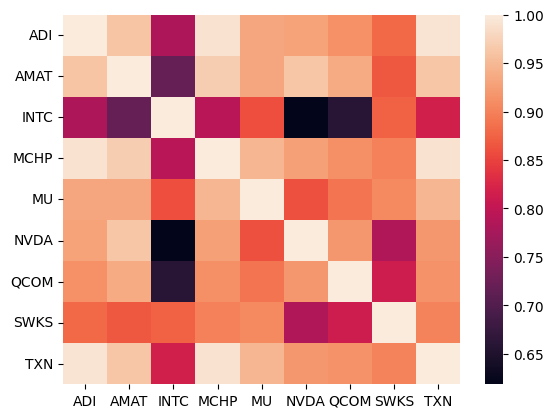

In [183]:
sns.heatmap(df[sc].corr())

<Axes: >

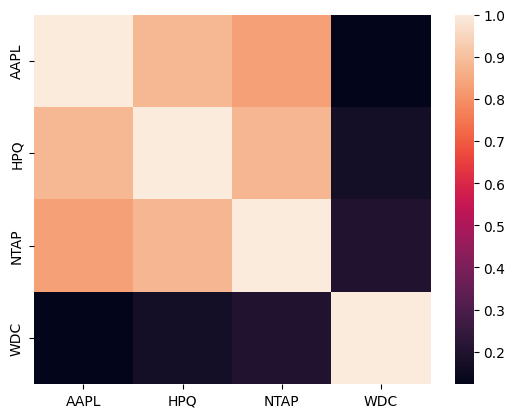

In [184]:
sns.heatmap(df[hd].corr())

<Axes: >

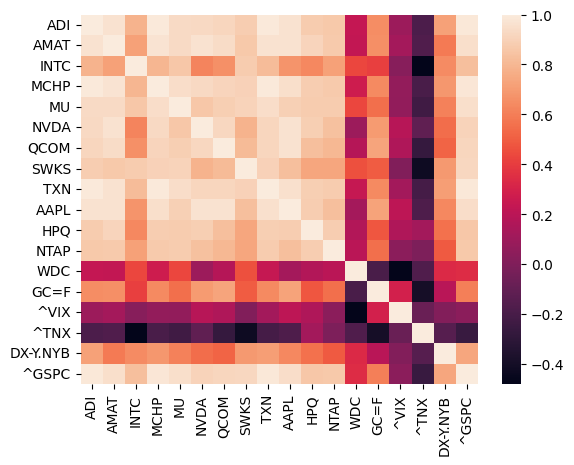

In [185]:
sns.heatmap(df.corr())

In [186]:
df[sc] = np.log(df[sc])

In [187]:
df[hd] = np.log(df[hd])

In [188]:
df["^GSPC"] = np.log(df["^GSPC"])

In [189]:
#dif = df.iloc[1: , :]

In [190]:
df

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,HPQ,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC
2009-05-01,2.698333,2.245379,2.319257,2.032141,1.571462,0.984544,3.386795,2.073473,2.520717,1.349935,2.439338,2.652049,2.932656,887.599976,35.299999,3.174,84.550003,6.777100
2009-05-04,2.740459,2.291899,2.371625,2.075831,1.646300,1.037121,3.402840,2.126283,2.543301,1.387191,2.456172,2.678860,2.969177,901.599976,34.529999,3.157,83.970001,6.810407
2009-05-05,2.737735,2.262473,2.349593,2.040859,1.678049,0.995622,3.406064,2.136519,2.515691,1.392026,2.446975,2.648237,2.975750,903.700012,33.360001,3.157,84.160004,6.806608
2009-05-06,2.765528,2.285610,2.347114,2.054224,1.668815,0.975073,3.411567,2.131414,2.540574,1.390442,2.434122,2.642767,2.984313,910.500000,32.450001,3.152,83.800003,6.823863
2009-05-07,2.717532,2.217912,2.325163,2.024670,1.577578,0.900566,3.379265,2.070213,2.499889,1.364137,2.383306,2.595594,2.933084,915.000000,33.439999,3.295,83.940002,6.810572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,5.226496,4.819485,3.381138,4.346649,4.186259,5.726271,4.626175,4.600742,5.118141,5.143584,3.402077,4.183365,3.632309,1972.400024,18.530001,3.698,103.489998,8.329798
2023-05-24,5.144926,4.799639,3.363705,4.293740,4.194106,5.721371,4.620947,4.580303,5.102286,5.145214,3.383583,4.180200,3.617115,1962.800049,20.030001,3.719,103.889999,8.322452
2023-05-25,5.140239,4.868977,3.306952,4.300779,4.239361,5.939459,4.630607,4.592277,5.117434,5.151884,3.413142,4.217096,3.633631,1943.099976,19.139999,3.814,104.209999,8.331172
2023-05-26,5.163970,4.910929,3.363705,4.355627,4.299572,5.964575,4.689681,4.647963,5.156004,5.165891,3.426004,4.232829,3.681603,1944.099976,17.950001,3.810,104.209999,8.344137


ADI


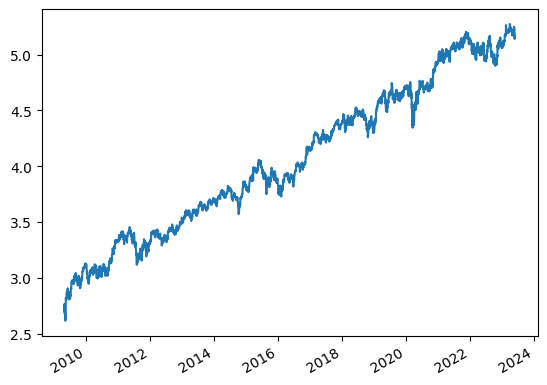

AMAT


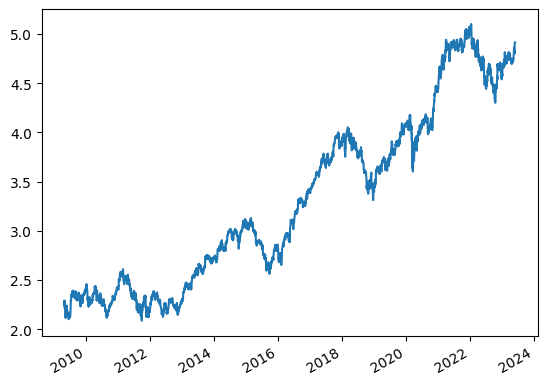

INTC


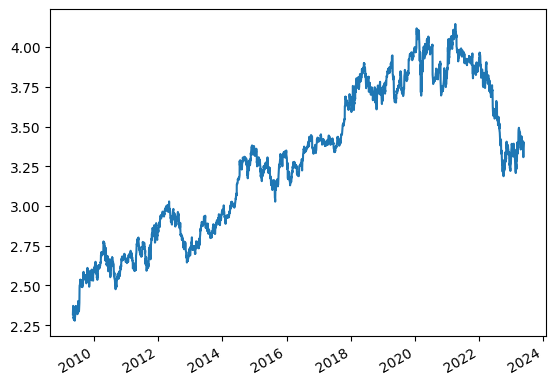

MCHP


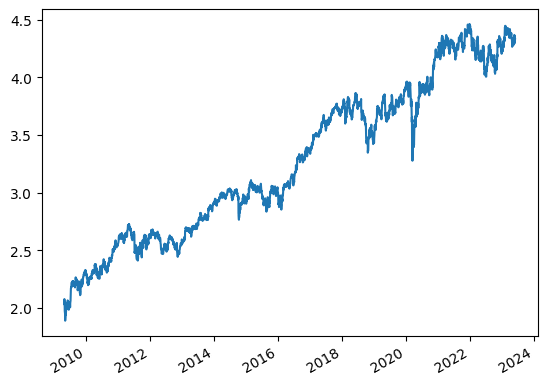

MU


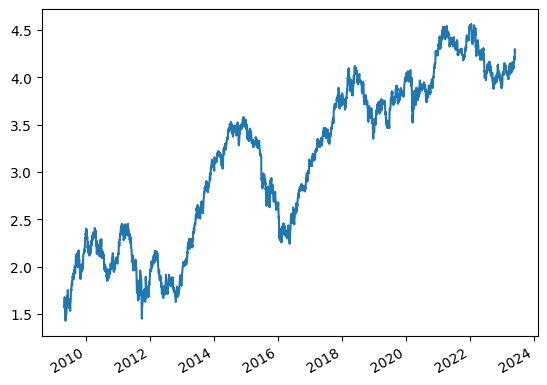

NVDA


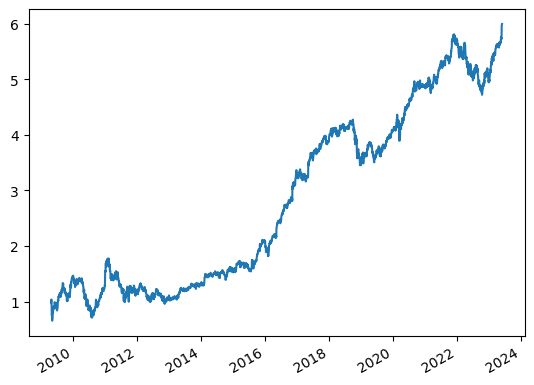

QCOM


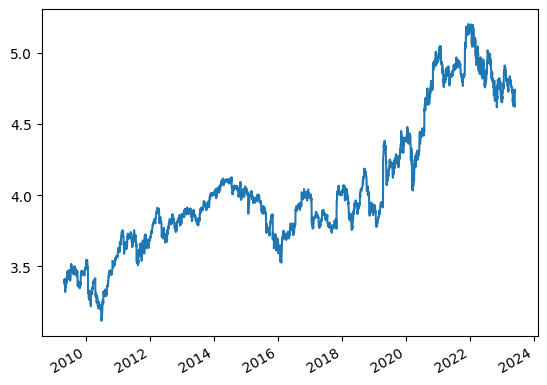

SWKS


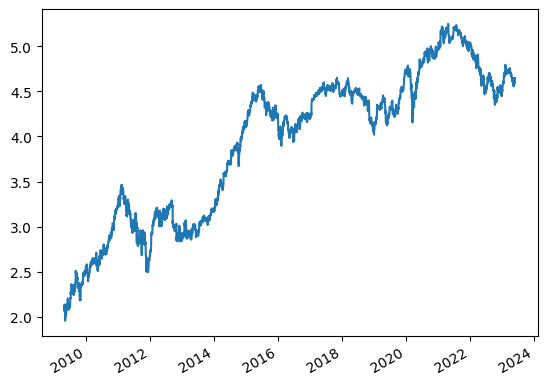

TXN


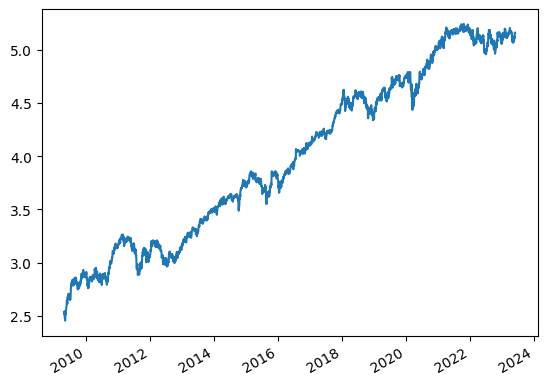

AAPL


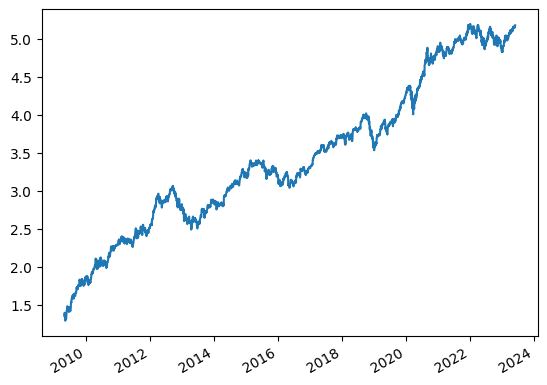

HPQ


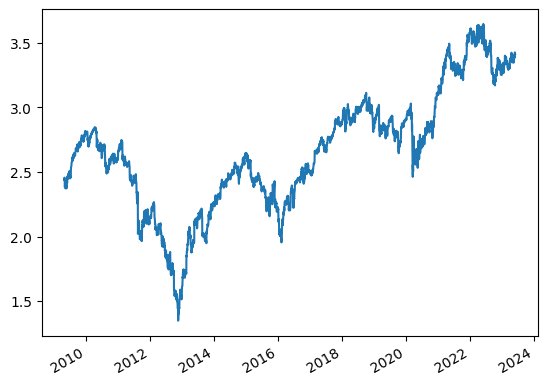

NTAP


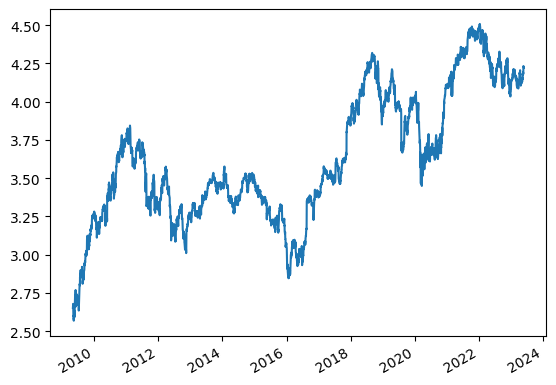

WDC


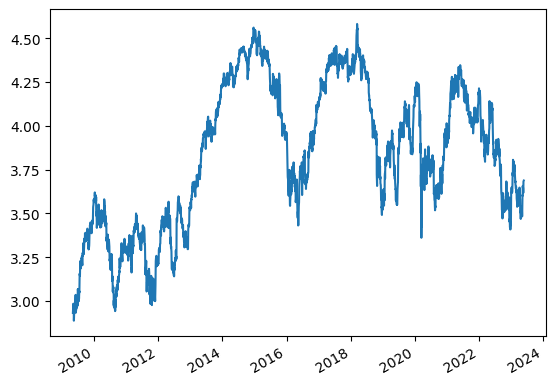

GC=F


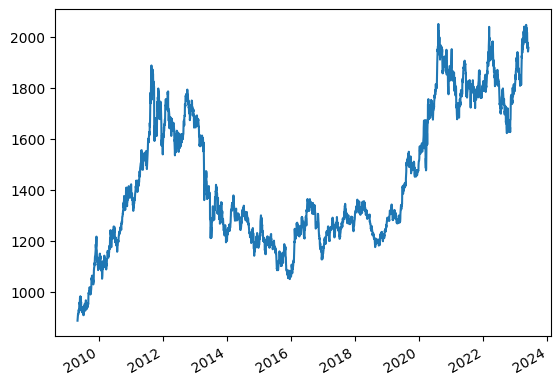

^VIX


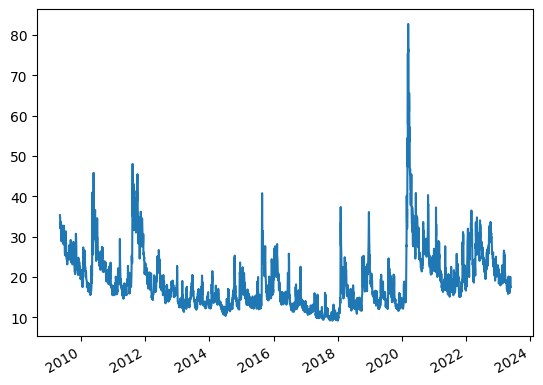

^TNX


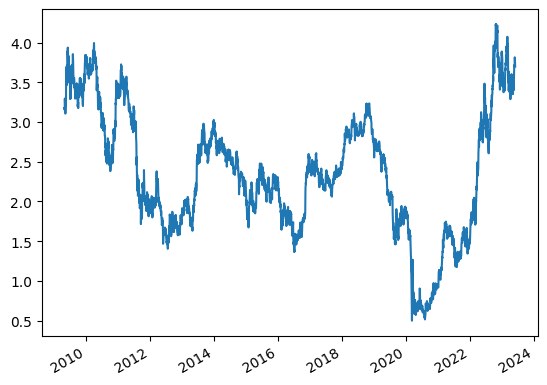

DX-Y.NYB


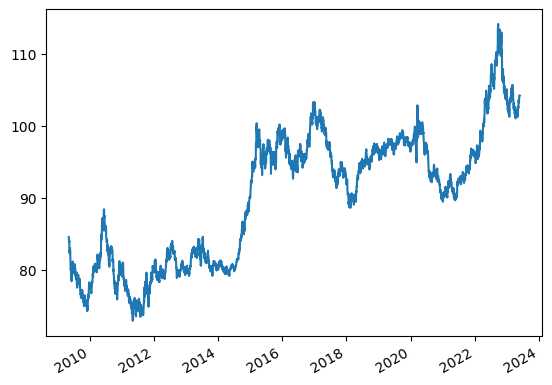

^GSPC


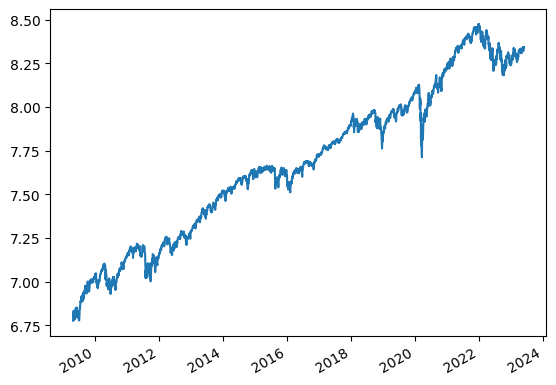

In [191]:
for column in df.columns:
    #plt.subplot(221)
    print(column)
    df[column].plot()
    plt.show()

ADI


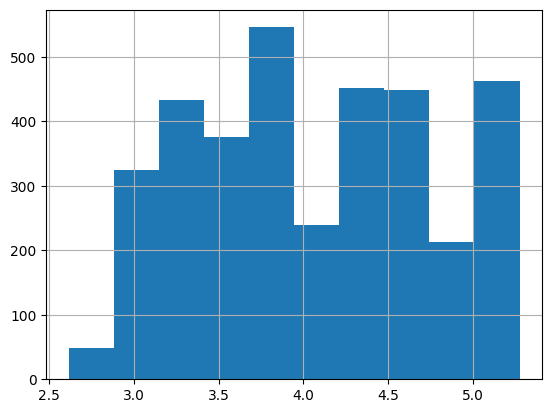

AMAT


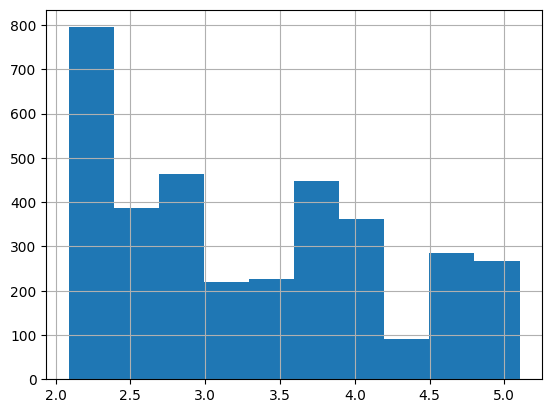

INTC


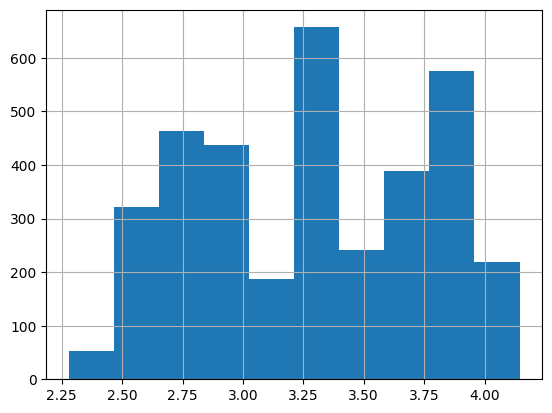

MCHP


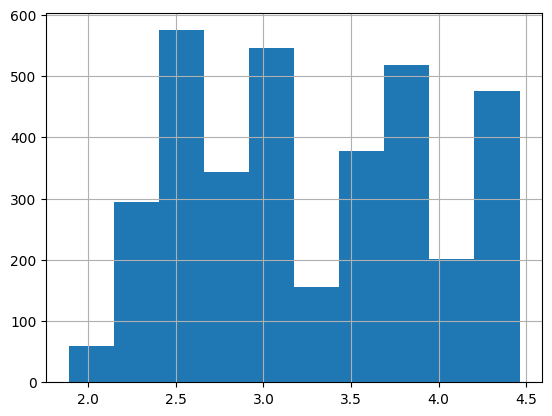

MU


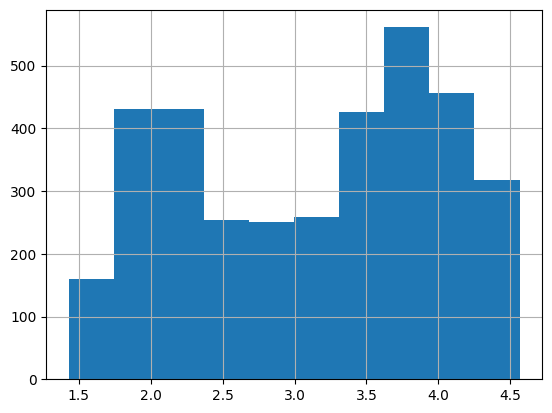

NVDA


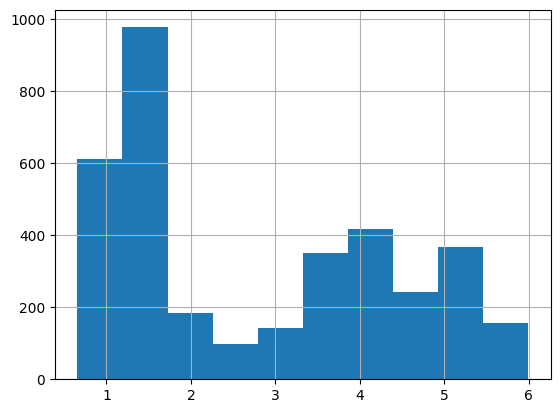

QCOM


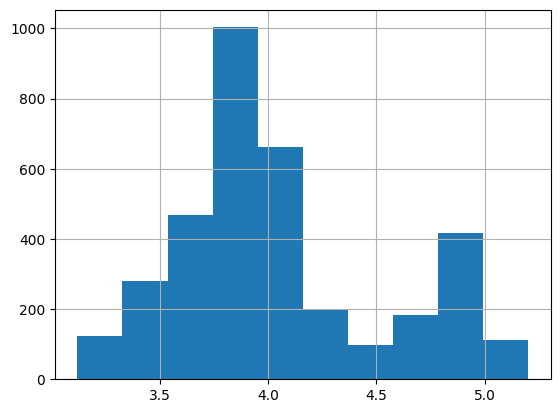

SWKS


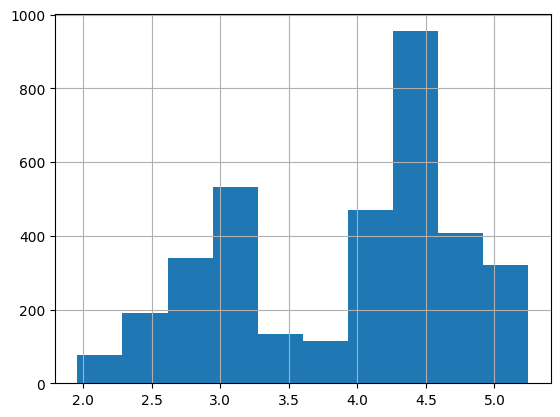

TXN


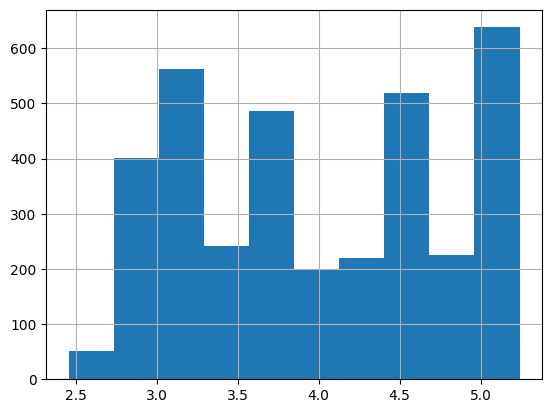

AAPL


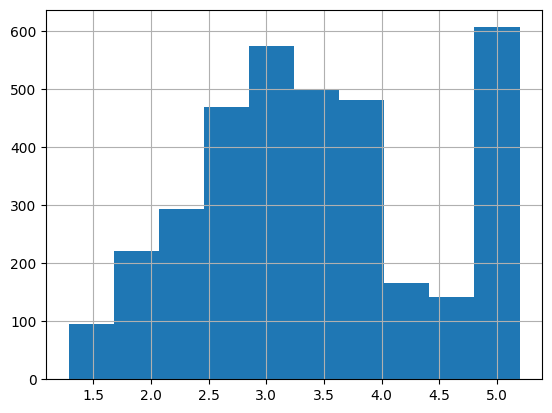

HPQ


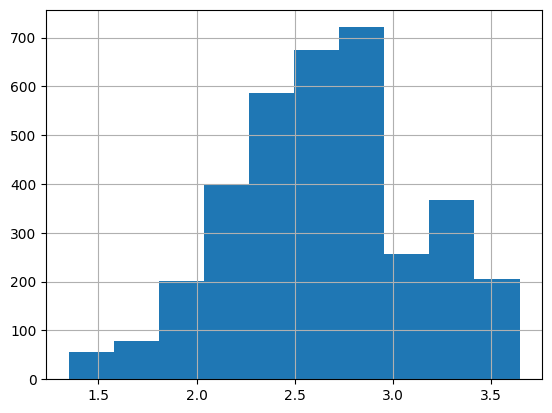

NTAP


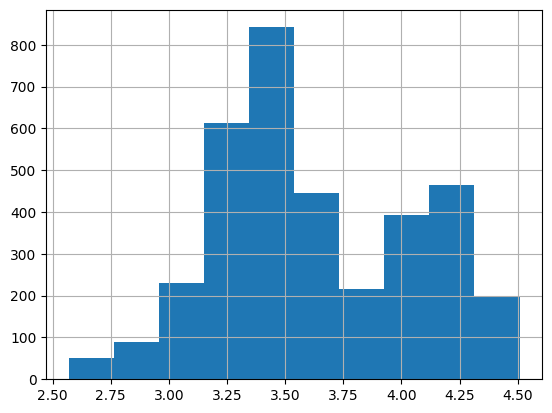

WDC


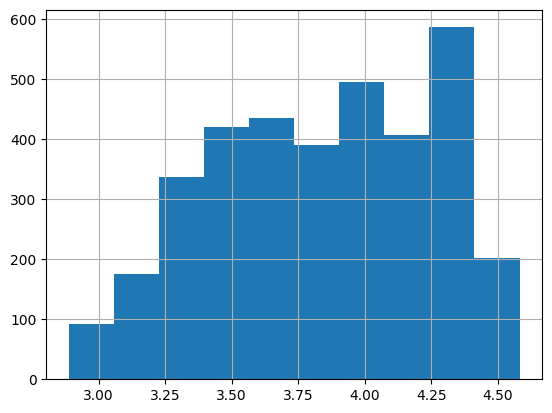

GC=F


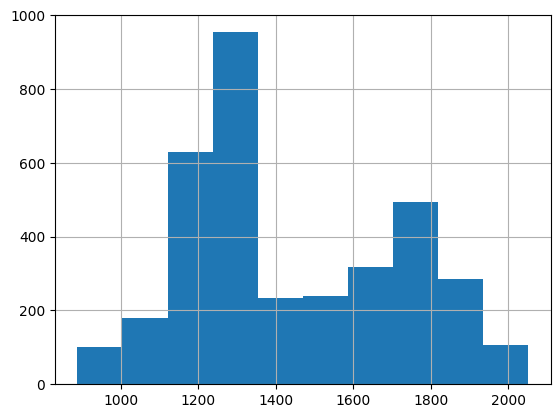

^VIX


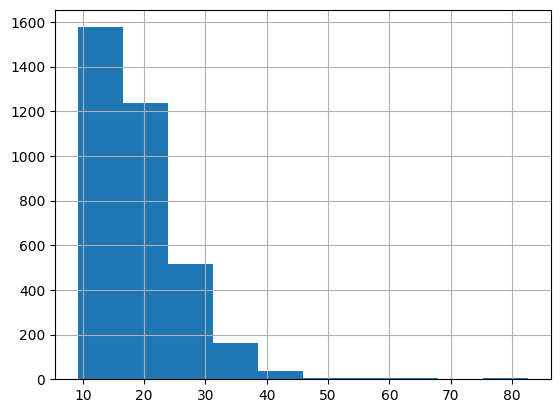

^TNX


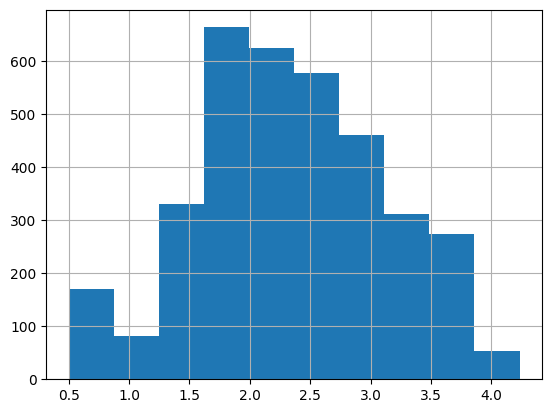

DX-Y.NYB


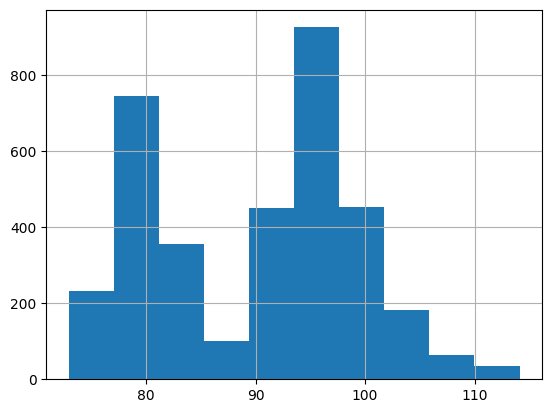

^GSPC


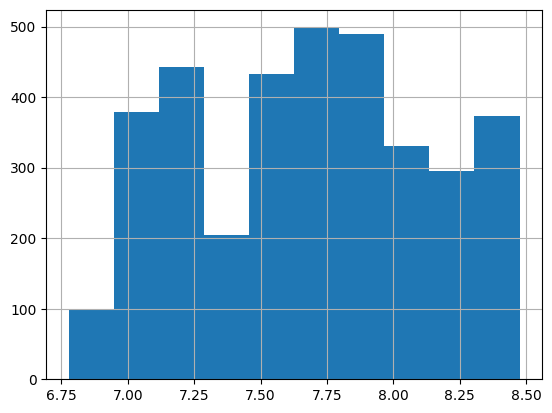

In [192]:
for column in df.columns:
    #plt.subplot(221)
    print(column)
    df[column].hist()
    plt.show()

In [193]:
df["semicon"] = df[sc].mean(axis=1)
df["hardware"] = df[hd].mean(axis=1)

In [194]:
df

,ADI,AMAT,INTC,MCHP,MU,NVDA,QCOM,SWKS,TXN,AAPL,HPQ,NTAP,WDC,GC=F,^VIX,^TNX,DX-Y.NYB,^GSPC,semicon,hardware
2009-05-01,2.698333,2.245379,2.319257,2.032141,1.571462,0.984544,3.386795,2.073473,2.520717,1.349935,2.439338,2.652049,2.932656,887.599976,35.299999,3.174,84.550003,6.777100,2.203567,2.343494
2009-05-04,2.740459,2.291899,2.371625,2.075831,1.646300,1.037121,3.402840,2.126283,2.543301,1.387191,2.456172,2.678860,2.969177,901.599976,34.529999,3.157,83.970001,6.810407,2.248407,2.372850
2009-05-05,2.737735,2.262473,2.349593,2.040859,1.678049,0.995622,3.406064,2.136519,2.515691,1.392026,2.446975,2.648237,2.975750,903.700012,33.360001,3.157,84.160004,6.806608,2.235845,2.365747
2009-05-06,2.765528,2.285610,2.347114,2.054224,1.668815,0.975073,3.411567,2.131414,2.540574,1.390442,2.434122,2.642767,2.984313,910.500000,32.450001,3.152,83.800003,6.823863,2.242213,2.362911
2009-05-07,2.717532,2.217912,2.325163,2.024670,1.577578,0.900566,3.379265,2.070213,2.499889,1.364137,2.383306,2.595594,2.933084,915.000000,33.439999,3.295,83.940002,6.810572,2.190310,2.319030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,5.226496,4.819485,3.381138,4.346649,4.186259,5.726271,4.626175,4.600742,5.118141,5.143584,3.402077,4.183365,3.632309,1972.400024,18.530001,3.698,103.489998,8.329798,4.670151,4.090334
2023-05-24,5.144926,4.799639,3.363705,4.293740,4.194106,5.721371,4.620947,4.580303,5.102286,5.145214,3.383583,4.180200,3.617115,1962.800049,20.030001,3.719,103.889999,8.322452,4.646780,4.081528
2023-05-25,5.140239,4.868977,3.306952,4.300779,4.239361,5.939459,4.630607,4.592277,5.117434,5.151884,3.413142,4.217096,3.633631,1943.099976,19.139999,3.814,104.209999,8.331172,4.681787,4.103938
2023-05-26,5.163970,4.910929,3.363705,4.355627,4.299572,5.964575,4.689681,4.647963,5.156004,5.165891,3.426004,4.232829,3.681603,1944.099976,17.950001,3.810,104.209999,8.344137,4.728003,4.126581


In [195]:
read = df[["DX-Y.NYB", "^TNX", "GC=F", "^VIX", "semicon", "hardware", "^GSPC"]]
read = df[["hardware", "semicon", "^GSPC", "^VIX", "GC=F", "^TNX", "DX-Y.NYB"]]
read

,hardware,semicon,^GSPC,^VIX,GC=F,^TNX,DX-Y.NYB
2009-05-01,2.343494,2.203567,6.777100,35.299999,887.599976,3.174,84.550003
2009-05-04,2.372850,2.248407,6.810407,34.529999,901.599976,3.157,83.970001
2009-05-05,2.365747,2.235845,6.806608,33.360001,903.700012,3.157,84.160004
2009-05-06,2.362911,2.242213,6.823863,32.450001,910.500000,3.152,83.800003
2009-05-07,2.319030,2.190310,6.810572,33.439999,915.000000,3.295,83.940002
...,...,...,...,...,...,...,...
2023-05-23,4.090334,4.670151,8.329798,18.530001,1972.400024,3.698,103.489998
2023-05-24,4.081528,4.646780,8.322452,20.030001,1962.800049,3.719,103.889999
2023-05-25,4.103938,4.681787,8.331172,19.139999,1943.099976,3.814,104.209999
2023-05-26,4.126581,4.728003,8.344137,17.950001,1944.099976,3.810,104.209999


In [196]:
for column in read.columns:
    read[column] =(read[column] - read[column].mean()) / read[column].std()
    
read
    

,hardware,semicon,^GSPC,^VIX,GC=F,^TNX,DX-Y.NYB
2009-05-01,-2.156064,-1.698353,-2.033621,2.241583,-2.042087,1.057181,-0.617491
2009-05-04,-2.095579,-1.641259,-1.958569,2.135238,-1.990516,1.035472,-0.681027
2009-05-05,-2.110214,-1.657254,-1.967129,1.973649,-1.982780,1.035472,-0.660213
2009-05-06,-2.116058,-1.649145,-1.928249,1.847969,-1.957732,1.029087,-0.699649
2009-05-07,-2.206471,-1.715232,-1.958196,1.984698,-1.941155,1.211698,-0.684313
...,...,...,...,...,...,...,...
2023-05-23,1.443172,1.442275,1.465128,-0.074522,1.953918,1.726331,1.457258
2023-05-24,1.425029,1.412519,1.448576,0.132643,1.918555,1.753148,1.501076
2023-05-25,1.471203,1.457092,1.468224,0.009725,1.845987,1.874463,1.536130
2023-05-26,1.517858,1.515937,1.497437,-0.154625,1.849671,1.869355,1.536130


hardware


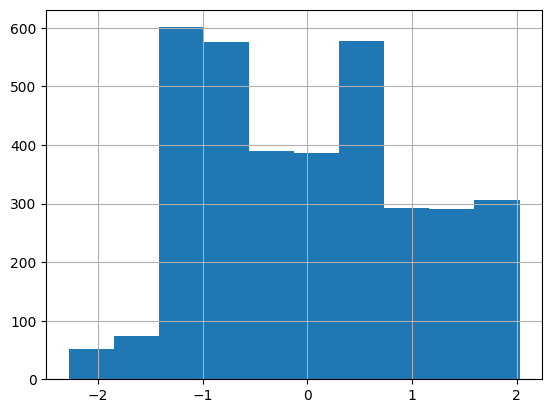

semicon


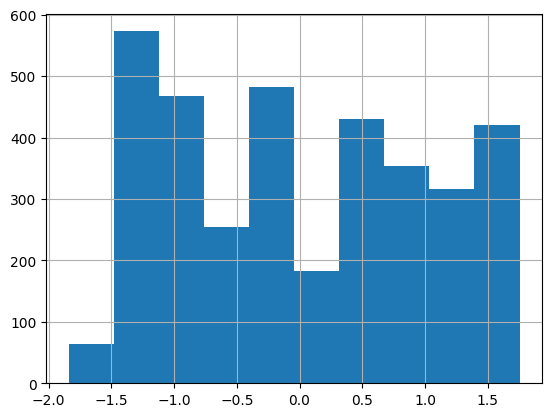

^GSPC


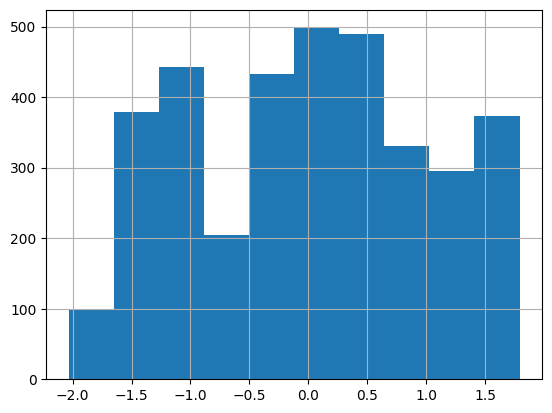

^VIX


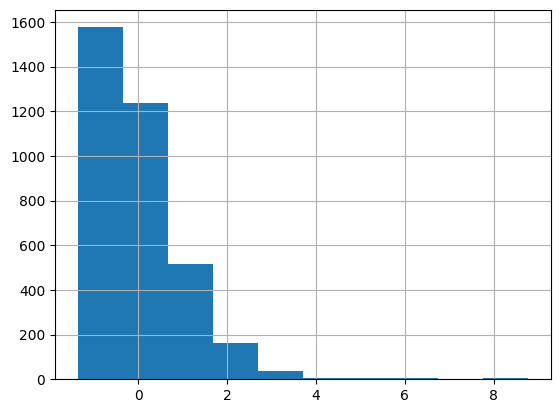

GC=F


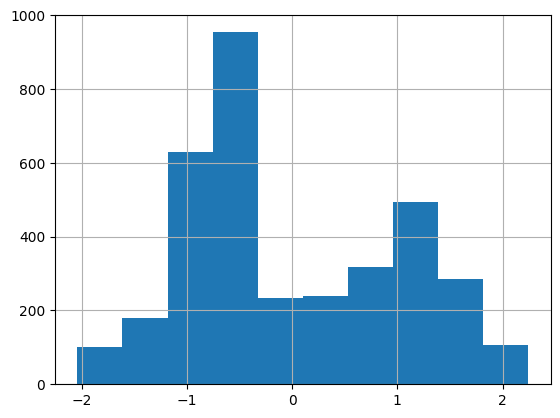

^TNX


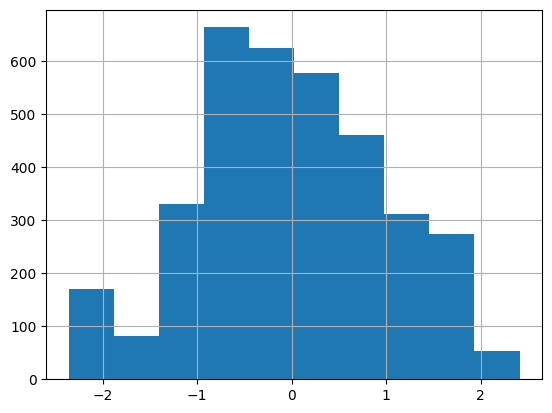

DX-Y.NYB


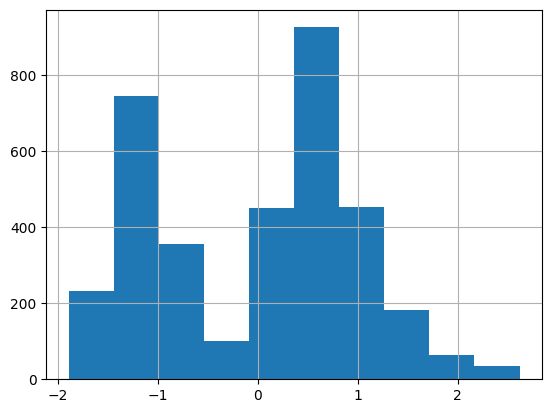

In [197]:
for column in read.columns:
    #plt.subplot(221)
    print(column)
    read[column].hist()
    plt.show()

hardware


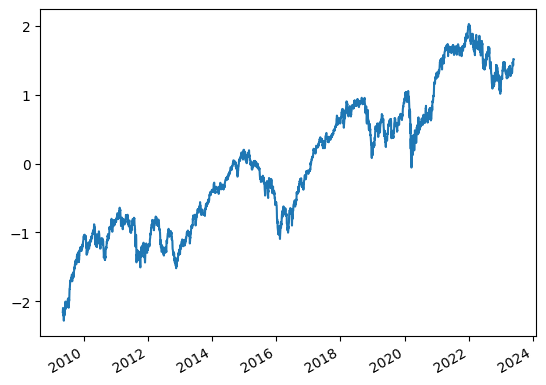

semicon


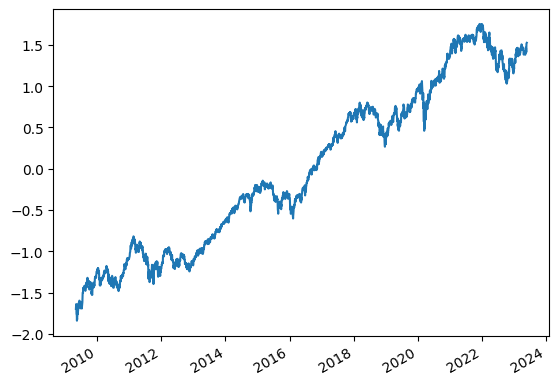

^GSPC


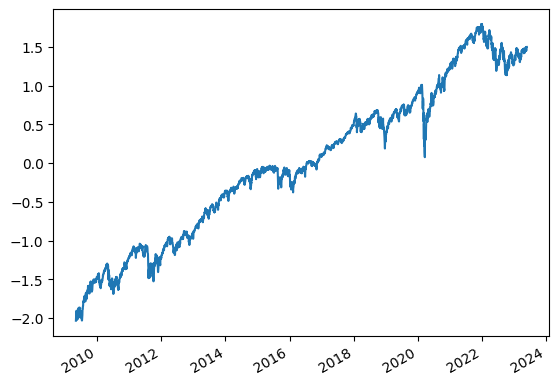

^VIX


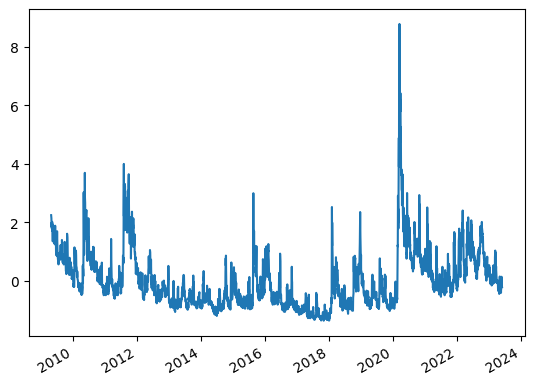

GC=F


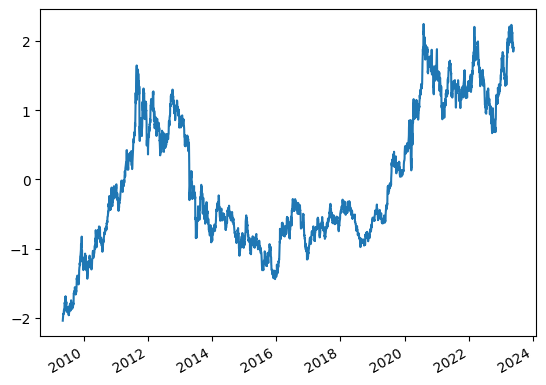

^TNX


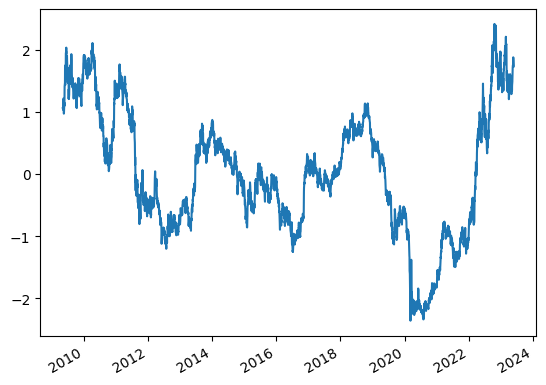

DX-Y.NYB


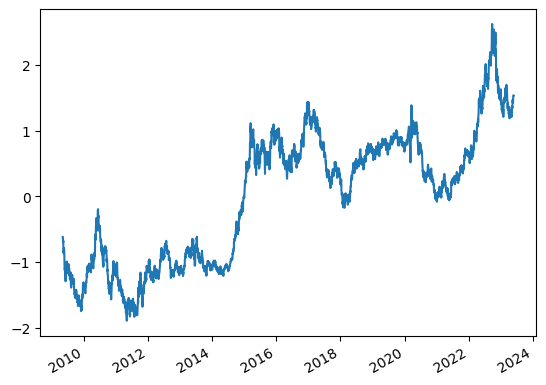

In [253]:
for column in read.columns:
    #plt.subplot(221)
    print(column)
    read[column].plot()
    plt.show()

# Unit root test
### - DFGLS
### - ADF
### - KPSS
### - PP

In [198]:
for column in read.columns:
    print(column)
    print(DFGLS(read[column], max_lags=10).summary())
    print("\n")
          

hardware
      Dickey-Fuller GLS Results      
Test Statistic                  0.937
P-value                         0.916
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -2.57 (1%), -1.95 (5%), -1.63 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


semicon
      Dickey-Fuller GLS Results      
Test Statistic                  1.818
P-value                         0.983
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -2.57 (1%), -1.95 (5%), -1.63 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


^GSPC
      Dickey-Fuller GLS Results      
Test Statistic                  1.753
P-value                         0.980
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -2.57 (1%),

In [199]:
for column in read.columns:
    print(column)
    print(ADF(read[column], max_lags=12).summary())
    print("\n")

hardware
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.693
P-value                         0.435
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


semicon
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.036
P-value                         0.740
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


^GSPC
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.323
P-value                         0.619
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%),

In [200]:
for column in read.columns:
    print(column)
    print(KPSS(read[column], lags=12).summary())
    print("\n")

hardware
    KPSS Stationarity Test Results   
Test Statistic                 24.399
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


semicon
    KPSS Stationarity Test Results   
Test Statistic                 26.798
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


^GSPC
    KPSS Stationarity Test Results   
Test Statistic                 26.580
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (

In [201]:
for column in read.columns:
    print(column)
    print(PhillipsPerron(read[column], lags=12).summary())
    print("\n")

hardware
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.591
P-value                         0.488
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


semicon
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.844
P-value                         0.806
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


^GSPC
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.377
P-value                         0.593
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%),

# VECM VAR lag order selection

In [202]:
order = vecm.select_order(read,maxlags=12, deterministic="cili", seasons=7) 
print(order.summary())


 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -45.30     -45.11*   2.111e-20      -45.23
1       -45.36      -45.08   1.992e-20     -45.26*
2       -45.37      -45.01   1.973e-20      -45.24
3       -45.37      -44.91   1.987e-20      -45.20
4       -45.39      -44.85   1.944e-20      -45.20
5       -45.38      -44.76   1.950e-20      -45.16
6       -45.38      -44.67   1.956e-20      -45.13
7      -45.39*      -44.59  1.943e-20*      -45.10
8       -45.38      -44.50   1.956e-20      -45.07
9       -45.39      -44.42   1.944e-20      -45.04
10      -45.38      -44.33   1.950e-20      -45.01
11      -45.38      -44.24   1.964e-20      -44.97
12      -45.37      -44.15   1.975e-20      -44.94
--------------------------------------------------


# VECM cointegration test

In [203]:
rank = vecm.select_coint_rank(read, det_order = 1, k_ar_diff = 7, method = 'maxeig', signif=0.01)
print(rank.summary())
    

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          91.13          55.82
  1   2          34.91          49.41
-------------------------------------


In [204]:
rank = vecm.select_coint_rank(read, det_order = 1, k_ar_diff = 7, method = 'trace', signif=0.01)
print(rank.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          187.5          150.1
  1   7          96.41          117.0
-------------------------------------


In [247]:
model = vecm.VECM(read.head(3444), k_ar_diff=7, coint_rank=1 ,deterministic='ci', seasons=7) 
res = model.fit()
print(res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation hardware
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
season1         0.0031      0.002      1.395      0.163      -0.001       0.007
season2      1.966e-05      0.002      0.009      0.993      -0.004       0.004
season3         0.0007      0.002      0.321      0.748      -0.004       0.005
season4         0.0021      0.002      0.970      0.332      -0.002       0.006
season5        -0.0008      0.002     -0.354      0.723      -0.005       0.004
season6         0.0042      0.002      1.916      0.055   -9.76e-05       0.009
L1.hardware    -0.0530      0.030     -1.740      0.082      -0.113       0.007
L1.semicon      0.1347      0.048      2.790      0.005       0.040       0.229
L1.^GSPC       -0.1701      0.058     -2.939      0.003      -0.283      -0.057
L1.^VIX        -0.0037      0.00

In [248]:
allpred = res.predict(steps=100)
pred = []
for step in allpred:
    pred.append(step[1])

pred

[1.2306605508326949,
 1.2324042372266828,
 1.2272084352489891,
 1.2341289372677036,
 1.2271207142862097,
 1.2267598139845497,
 1.2279804692632212,
 1.2275264845237548,
 1.2271983390310606,
 1.226430165298169,
 1.2284483416080443,
 1.2268181722722498,
 1.2289563339343919,
 1.2276777256557285,
 1.2282116025263758,
 1.2276825074748172,
 1.227449305539151,
 1.2282841216479718,
 1.2272924951446407,
 1.2293918655066056,
 1.2277736730200939,
 1.2284833657653342,
 1.2277509765698098,
 1.2277620613713187,
 1.2283935925188485,
 1.2275028671993826,
 1.2296332607823544,
 1.2279566676729632,
 1.2287170244135208,
 1.2279242975132525,
 1.2279807918584071,
 1.2285709746420794,
 1.2276872612339171,
 1.2298199258180569,
 1.2281280350552757,
 1.2288983934948232,
 1.228089692146545,
 1.2281538067561764,
 1.228734520472588,
 1.2278493125469427,
 1.2299804796595128,
 1.22828277069982,
 1.229053319951687,
 1.2282388248741993,
 1.2283022657582483,
 1.2288790631123072,
 1.2279913009182908,
 1.230120215344848,


In [249]:
statsmodels.tools.eval_measures.meanabs(pred[7:], read["hardware"].tail(93))

0.12805084787799012

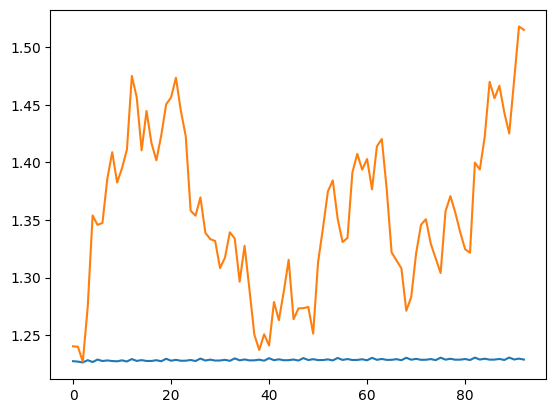

In [250]:
plt.plot(pred[7:])
plt.plot(read["hardware"].tail(93).to_numpy())
plt.show()

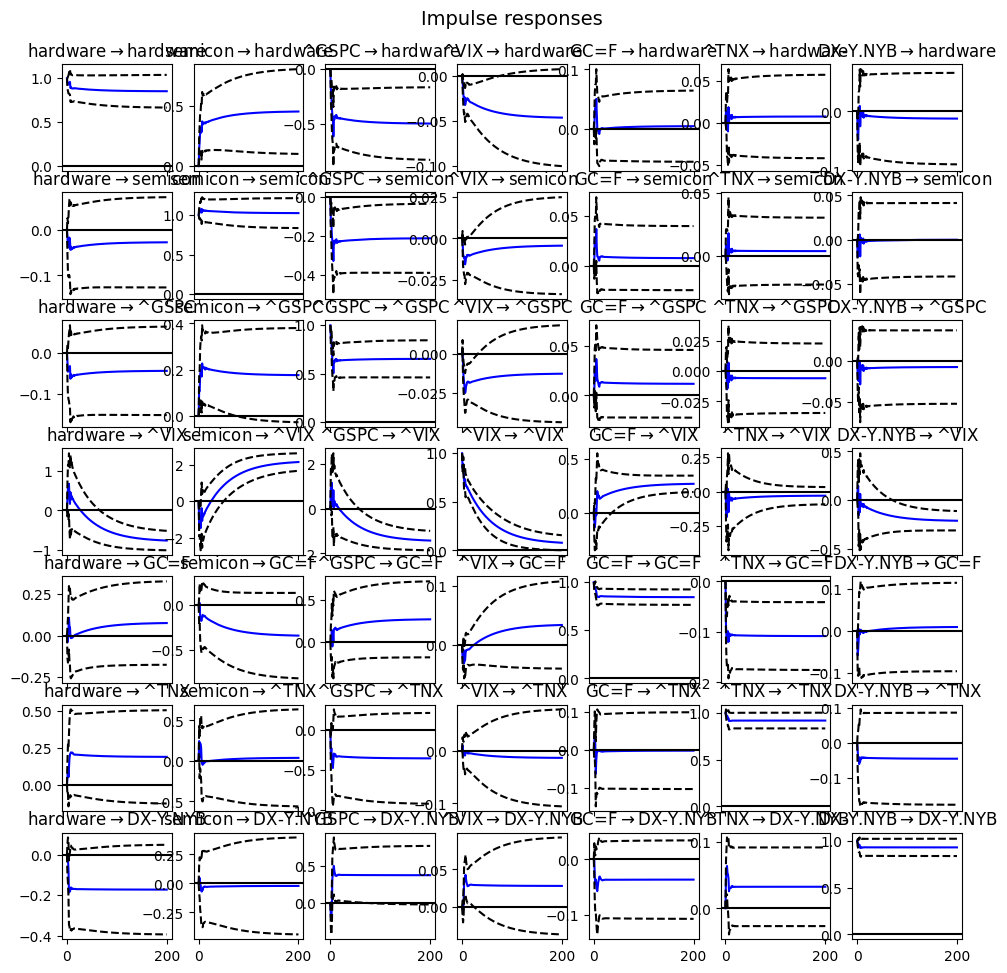

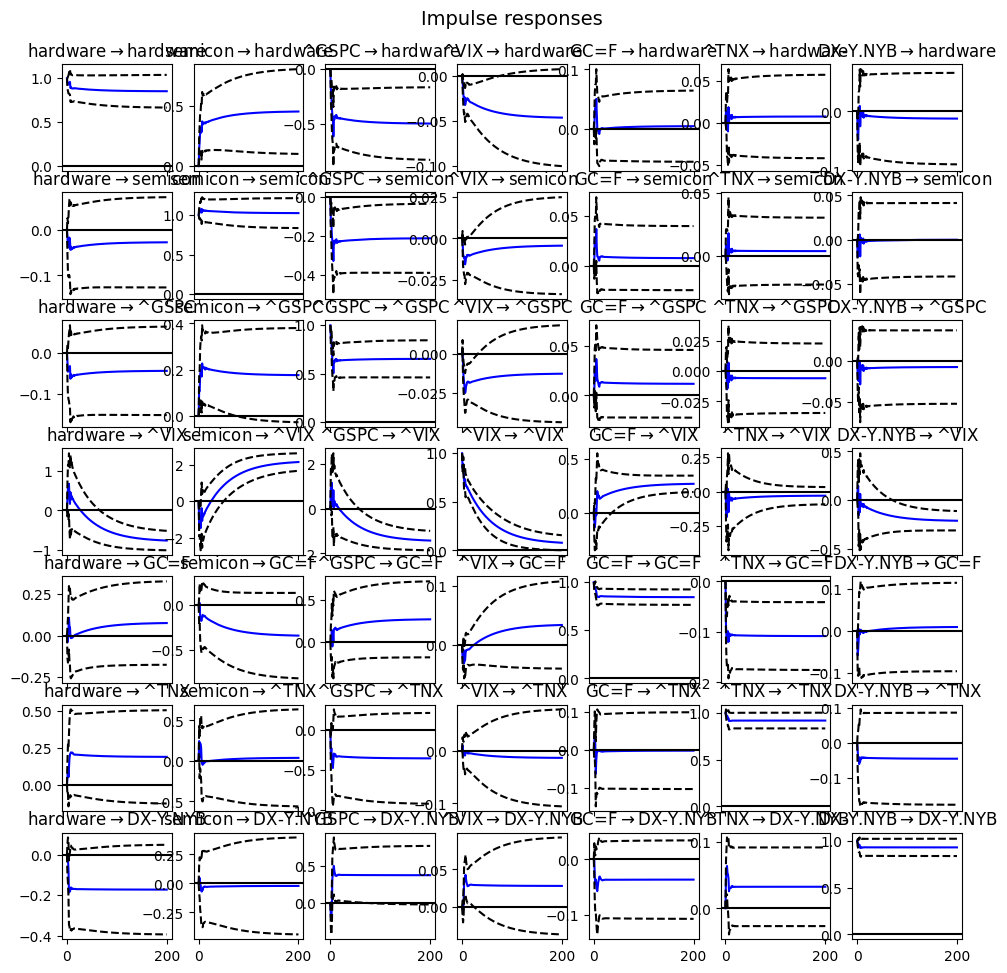

In [214]:
res.irf(200).plot()

In [215]:
causality_vs_each(read, res)

Granger causality F-test. H_0: semicon does not Granger-cause hardware. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         2.036          1.939   0.039 (8, 23450)
------------------------------------------------


Granger causality F-test. H_0: ^GSPC does not Granger-cause hardware. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         2.787          1.939   0.004 (8, 23450)
------------------------------------------------


Granger causality F-test. H_0: ^VIX does not Granger-cause hardware. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         2.746          1.939   0.005 (8, 23450)
------------------------------------------------


Granger causality F-test. H_0: GC=F does not Gra

Granger causality F-test. H_0: semicon does not Granger-cause GC=F. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.195          1.939   0.297 (8, 23450)
------------------------------------------------


Granger causality F-test. H_0: ^GSPC does not Granger-cause GC=F. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.932          1.939   0.051 (8, 23450)
------------------------------------------------


Granger causality F-test. H_0: ^VIX does not Granger-cause GC=F. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         4.190          1.939   0.000 (8, 23450)
------------------------------------------------


Granger causality F-test. H_0: ^TNX does not

In [216]:
res.alpha*res.beta

array([[-1.38015165e-03],
       [ 7.05933039e-04],
       [-9.33852741e-04],
       [-2.19350926e-02],
       [-3.35202353e-04],
       [-6.55731394e-07],
       [ 1.69457953e-04]])

In [217]:
res.gamma

array([[-5.74999990e-02,  1.35076810e-01, -1.77037038e-01,
        -4.61658674e-03, -3.03095887e-03,  1.33557741e-02,
        -3.95441176e-02, -9.50847633e-03,  8.31533640e-02,
        -7.61780511e-02, -8.86461049e-03,  3.07693894e-02,
         1.23976789e-04, -9.87000687e-03, -2.92658711e-03,
         7.71954681e-02, -1.10820442e-01, -8.61704079e-03,
         7.92996109e-03, -1.83497612e-02,  3.38345026e-02,
         2.00871547e-02, -8.57530591e-03, -6.83334019e-02,
        -4.11587445e-03, -6.52751152e-03, -8.76220822e-04,
        -3.18546895e-03,  7.83409318e-03,  4.72821104e-02,
        -2.94670076e-02,  2.33278750e-03,  2.23148605e-02,
        -7.05349453e-03,  2.26911587e-02,  2.33576852e-03,
        -2.42271364e-02, -1.90884066e-01, -9.39425399e-03,
        -1.86444423e-02,  2.79086981e-02, -2.98251215e-02,
        -6.82675378e-02,  9.19979553e-02,  1.02806746e-01,
        -1.92119856e-03, -2.80422137e-02, -1.45978859e-02,
         1.57067444e-02],
       [-1.36485776e-02,  1.90

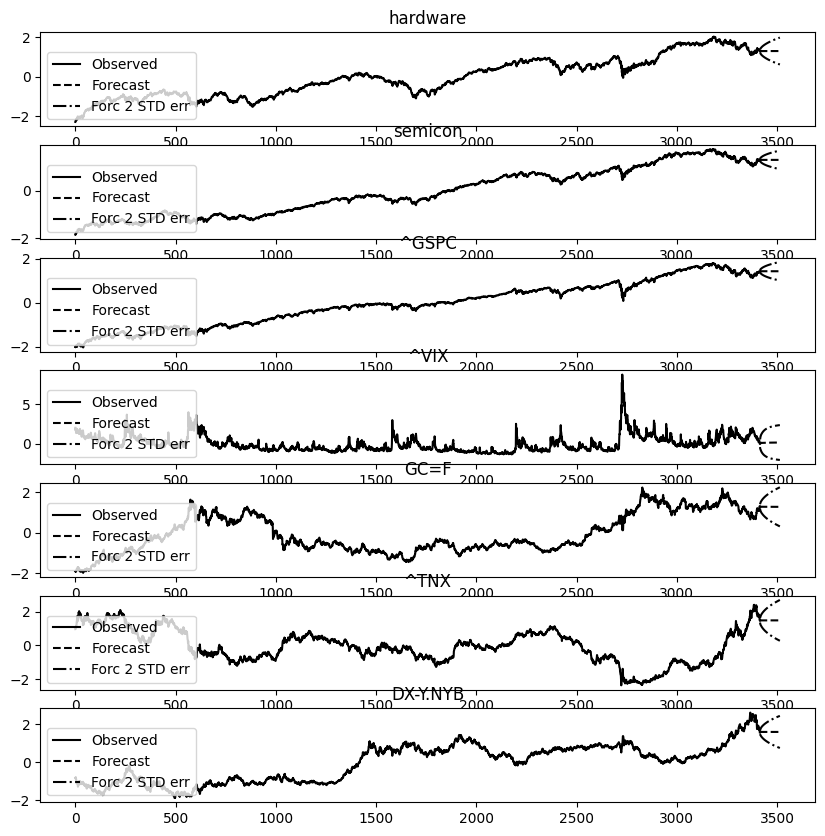

In [220]:
res.plot_forecast(100)